In [195]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import plotly.graph_objects as go
from typing import Tuple, Optional, NamedTuple, Any, List
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from pathlib import Path
import common
import numpy
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import activations
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import load_model
from functools import lru_cache

# Plan:

1. get apple data
2. clean it
3. split into train + test + validation
4. normelize it (using test scaler)
5. create basic LSTM model that can use just one stock's data
6. see how well I did

7. add other stock's data
8. check the model again (should I use the same model or a different one?)
9. think


In [196]:
apple_data = common.get_dukas_data("AAPL")
apple_data

,Local time,Open,High,Low,Close,Volume
0,01.01.2019 00:00:00.000 GMT+0200,157.718,157.718,157.718,157.718,0.0
1,01.01.2019 00:01:00.000 GMT+0200,157.718,157.718,157.718,157.718,0.0
2,01.01.2019 00:02:00.000 GMT+0200,157.718,157.718,157.718,157.718,0.0
3,01.01.2019 00:03:00.000 GMT+0200,157.718,157.718,157.718,157.718,0.0
4,01.01.2019 00:04:00.000 GMT+0200,157.718,157.718,157.718,157.718,0.0
...,...,...,...,...,...,...
1736755,31.12.2018 23:55:00.000 GMT+0200,157.718,157.718,157.718,157.718,0.0
1736756,31.12.2018 23:56:00.000 GMT+0200,157.718,157.718,157.718,157.718,0.0
1736757,31.12.2018 23:57:00.000 GMT+0200,157.718,157.718,157.718,157.718,0.0
1736758,31.12.2018 23:58:00.000 GMT+0200,157.718,157.718,157.718,157.718,0.0


In [197]:
def preprocess_data_from_dukas(df):
    
    # rename columns
    new_cols_map = {col: col.lower() for col in df}
    new_cols_map['Local time'] = "datetime"
    df = df.rename(columns=new_cols_map)

    # convert datetime type (string to datetime)
    df['datetime'] = df['datetime'].str.replace(r"\:00\.000 GMT\+0\d00","")
    df['datetime'] = pd.to_datetime(df['datetime'], format='%d.%m.%Y %H:%M')
    
    df = df.set_index(['datetime']).between_time("16:30", "23:00").reset_index()
    df = df.sort_values(by=['datetime'])
    
    # drop inactive days
    df['day_of_week'] = df['datetime'].dt.dayofweek
    mask = (df['day_of_week'] != 5) & (df['day_of_week'] != 6)
    df = df[mask]
    del df['day_of_week']
    df = df.reset_index(drop=True)

    return df

apple_data = preprocess_data_from_dukas(apple_data)
apple_data


,datetime,open,high,low,close,volume
0,2017-01-26 16:30:00,121.680,121.894,121.660,121.710,0.4459
1,2017-01-26 16:31:00,121.720,121.894,121.702,121.891,0.3697
2,2017-01-26 16:32:00,121.851,122.090,121.840,122.060,0.4814
3,2017-01-26 16:33:00,122.070,122.240,122.053,122.240,0.6113
4,2017-01-26 16:34:00,122.240,122.430,122.150,122.213,0.6310
...,...,...,...,...,...,...
337484,2020-05-22 22:56:00,318.317,318.538,318.238,318.438,3.4204
337485,2020-05-22 22:57:00,318.448,318.678,318.388,318.677,3.6803
337486,2020-05-22 22:58:00,318.678,318.918,318.638,318.818,3.8403
337487,2020-05-22 22:59:00,318.818,319.168,318.688,318.688,3.5204


In [198]:
PREDICTION_RANGE = 10
apple_data['target'] = apple_data['close'].shift(-PREDICTION_RANGE)
apple_data.dropna(inplace=True)
apple_data

,datetime,open,high,low,close,volume,target
0,2017-01-26 16:30:00,121.680,121.894,121.660,121.710,0.4459,122.053
1,2017-01-26 16:31:00,121.720,121.894,121.702,121.891,0.3697,121.973
2,2017-01-26 16:32:00,121.851,122.090,121.840,122.060,0.4814,122.030
3,2017-01-26 16:33:00,122.070,122.240,122.053,122.240,0.6113,121.990
4,2017-01-26 16:34:00,122.240,122.430,122.150,122.213,0.6310,122.033
...,...,...,...,...,...,...,...
337474,2020-05-22 22:46:00,318.237,318.285,318.098,318.178,2.9602,318.438
337475,2020-05-22 22:47:00,318.178,318.197,317.978,318.038,2.4803,318.677
337476,2020-05-22 22:48:00,318.018,318.155,317.997,318.138,2.3202,318.818
337477,2020-05-22 22:49:00,318.137,318.138,317.757,317.897,2.1402,318.688


In [199]:
# i will start using only close prices
apple_close_price = apple_data[['close', 'volume']].values
apple_targets = apple_data['target'].values.reshape(-1, 1)

In [200]:
from dataclasses import dataclass

@dataclass
class SingleDataSet:
    X: np.array
    y: np.array
    
    def generator(self, shuffle=False):
        return TimeseriesGenerator(self.X, self.y, length=500, sampling_rate=1, stride=1, 
                                   batch_size=128, shuffle=shuffle)


class FullDataSet(NamedTuple):
    training: SingleDataSet
    validation: SingleDataSet
    test: SingleDataSet

    x_scaler: Optional[MinMaxScaler] = None
    y_scaler: Optional[MinMaxScaler] = None

    def normelize(self):
        x_scaler = MinMaxScaler()
        y_scaler = MinMaxScaler()
        x_scaler.fit(self.training.X)
        y_scaler.fit(self.training.y)
        datasets = []
        for dataset in [self.training, self.validation, self.test]:
            new_X = x_scaler.transform(dataset.X)
            new_y = y_scaler.transform(dataset.y)
            datasets.append(SingleDataSet(new_X, new_y))
        return FullDataSet(*datasets, x_scaler, y_scaler)


def train_val_test_split(samples, features) -> FullDataSet:
    X_train, X_test, y_train, y_test = train_test_split(
        samples, features, test_size=0.2, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.25, shuffle=False)
    train = SingleDataSet(X_train, y_train)
    validation = SingleDataSet(X_val, y_val)
    test = SingleDataSet(X_test, y_test)
    return FullDataSet(train, validation, test)


dataset = train_val_test_split(apple_close_price, apple_targets)
dataset

FullDataSet(training=SingleDataSet(X=array([[121.71  ,   0.4459],
       [121.891 ,   0.3697],
       [122.06  ,   0.4814],
       ...,
       [156.787 ,   0.    ],
       [156.787 ,   0.    ],
       [156.787 ,   0.    ]]), y=array([[122.053],
       [121.973],
       [122.03 ],
       ...,
       [156.787],
       [156.787],
       [156.787]])), validation=SingleDataSet(X=array([[156.787 ,   0.    ],
       [156.787 ,   0.    ],
       [156.787 ,   0.    ],
       ...,
       [219.158 ,   2.7875],
       [218.828 ,   5.055 ],
       [219.118 ,   4.2175]]), y=array([[156.787],
       [156.787],
       [156.787],
       ...,
       [218.928],
       [219.148],
       [219.208]])), test=SingleDataSet(X=array([[219.288 ,   3.3825],
       [219.407 ,   3.    ],
       [219.478 ,   2.185 ],
       ...,
       [318.138 ,   2.3202],
       [317.897 ,   2.1402],
       [317.908 ,   4.7004]]), y=array([[219.378],
       [219.217],
       [219.287],
       ...,
       [318.818],
       [318.688

<module 'matplotlib.pyplot' from '/Users/alon/opt/anaconda3/envs/data_science/lib/python3.7/site-packages/matplotlib/pyplot.py'>

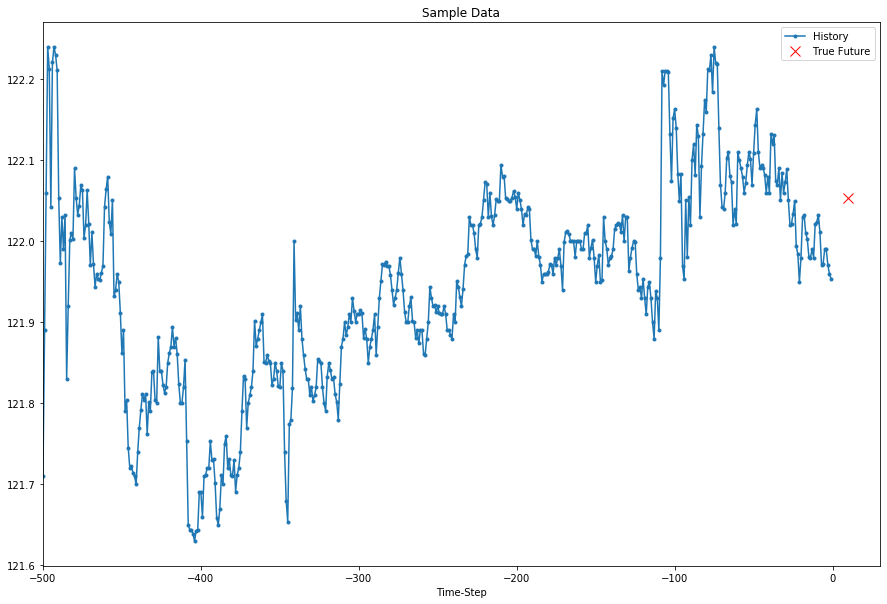

In [201]:
def create_time_steps(length):
    return list(range(-length, 0))


def show_plot(title, features: np.array, target: np.float64, prediction=None, delta=None):
    plt.figure(figsize=(15, 10))
    
    plot_data = [features, target]
    if prediction:
        plot_data.append(prediction)
        
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                     label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(
            ), marker[i], label=labels[i])
            
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt


show_plot("Sample Data", dataset.training.X[:500, 0], dataset.training.y[0], delta=PREDICTION_RANGE)

In [202]:
normelize_dataset = dataset.normelize()
normelize_dataset

FullDataSet(training=SingleDataSet(X=array([[0.00940817, 0.12275968],
       [0.01101466, 0.10178124],
       [0.01251464, 0.13253311],
       ...,
       [0.32073881, 0.        ],
       [0.32073881, 0.        ],
       [0.32073881, 0.        ]]), y=array([[0.01245252],
       [0.01174246],
       [0.01224838],
       ...,
       [0.32073881],
       [0.32073881],
       [0.32073881]])), validation=SingleDataSet(X=array([[0.32073881, 0.        ],
       [0.32073881, 0.        ],
       [0.32073881, 0.        ],
       ...,
       [0.87432101, 0.76742009],
       [0.87139205, 1.3916802 ],
       [0.87396599, 1.16111004]]), y=array([[0.32073881],
       [0.32073881],
       [0.32073881],
       ...,
       [0.87227962],
       [0.87423226],
       [0.8747648 ]])), test=SingleDataSet(X=array([[0.87547485, 0.93122815],
       [0.87653105, 0.82592297],
       [0.87716122, 0.60154723],
       ...,
       [1.75283133, 0.63876882],
       [1.7506923 , 0.58921345],
       [1.75078993, 1.294056

<module 'matplotlib.pyplot' from '/Users/alon/opt/anaconda3/envs/data_science/lib/python3.7/site-packages/matplotlib/pyplot.py'>

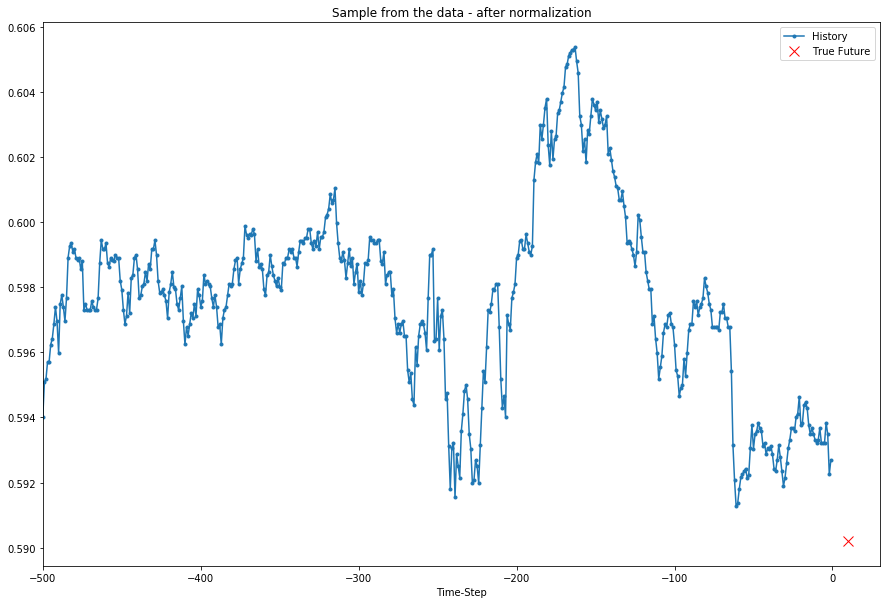

In [203]:
batch_0 = normelize_dataset.training.generator(shuffle=True)[0]
x, y = batch_0
show_plot("Sample from the data - after normalization", x[0][:, 0], y[0][0], delta=PREDICTION_RANGE)

In [204]:

def get_callbacks(model_name: str):
    # define the checkpoint
    filepath="weights_improvement_" + model_name + "_{epoch:02d}-{loss:.4f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

    # tensorboard
    log_dir = f'logs/fit/{model_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)


    return [checkpoint, tensorboard_callback]



In [49]:
input_shape = normelize_dataset.training.generator[0][0][0].shape

lstm_model = Sequential()
lstm_model.add(LSTM(100, activation='relu', input_shape=input_shape))
lstm_model.add(Dense(1))
lstm_model.compile(tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1), loss='mse')

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               41200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 41,301
Trainable params: 41,301
Non-trainable params: 0
_________________________________________________________________


In [52]:
# !rm -rf ./logs/ 
    
lstm_model.fit(
    training_generator,epochs=20, steps_per_epoch=150,
                      validation_data=val_generator, validation_steps=50, callbacks=get_callbacks("lstm"))


Train for 150 steps, validate for 50 steps
Epoch 1/20
149/150 [============================>.] - ETA: 1s - loss: 0.0116
Epoch 00001: loss improved from inf to 0.01153, saving model to weights-improvement-01-0.0115.hdf5
150/150 [==============================] - 339s 2s/step - loss: 0.0115 - val_loss: 7.2441e-05
Epoch 2/20
149/150 [============================>.] - ETA: 1s - loss: 3.0231e-05
Epoch 00002: loss improved from 0.01153 to 0.00003, saving model to weights-improvement-02-0.0000.hdf5
150/150 [==============================] - 322s 2s/step - loss: 3.0160e-05 - val_loss: 3.5304e-05
Epoch 3/20
149/150 [============================>.] - ETA: 1s - loss: 2.4289e-05
Epoch 00003: loss improved from 0.00003 to 0.00002, saving model to weights-improvement-03-0.0000.hdf5
150/150 [==============================] - 333s 2s/step - loss: 2.4196e-05 - val_loss: 4.7591e-05
Epoch 4/20
149/150 [============================>.] - ETA: 1s - loss: 2.5662e-05
Epoch 00004: loss did not improve from 0.0

In [53]:
lstm_model.save("lstm_model_v2")


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: lstm_model_v2/assets


In [62]:
model = load_model('weights-improvement-17-0.0000.hdf5')

In [228]:
def plot_one_prediction_from_generator(model, generator: TimeseriesGenerator):
    batch0 = generator[0]
    x, y = batch0
    sample = batch0[0][0]
    target = batch0[1][0]
    sample = sample.reshape((1, *sample.shape))
    prediction = model.predict(sample)
    # show_plot("Prediction of the model on validation data", x[0][:, 0], y[0][0], prediction=prediction, delta=PREDICTION_RANGE)

    x = x_scaler.inverse_transform(x[0])
    y = y_scaler.inverse_transform(y)
    prediction = y_scaler.inverse_transform(prediction)
    print(prediction)
    show_plot("Prediction of the model on validation data, not normelized", x[:, 0], y[0][0], prediction=prediction, delta=PREDICTION_RANGE)


In [206]:
def pnl_using_price(curr_price, predicted_price, true_price):    
    predicted_roc = predicted_price / curr_price - 1
    true_roc = true_price / curr_price - 1
    return rate_of_change_PnL(predicted_roc, true_roc)


# from common.py - will return a vector of profits/losses (percentage wise) for every trade
def rate_of_change_PnL(pred_roc, actual_roc):
    """ calculate the profit/loss of every prediction """
    return (pred_roc > 0) * actual_roc - (pred_roc < 0) * actual_roc


def mean(l: list) -> float:
    return sum(l) / len(l)


def calculate_model_pnl(model, dataset: FullDataSet, data_to_use: str) -> float:
    data_generator = getattr(dataset, data_to_use).generator()
    # checking how well the model did:
    pnls = []
    for batch in data_generator:
        samples, targets = batch
        predictions = model.predict(samples)
        for sample, target, prediction in zip(samples, targets, predictions):
            original_last_price_point = dataset.x_scaler.inverse_transform(sample)[:, 0][-1]
            original_prediction = dataset.y_scaler.inverse_transform(prediction.reshape(1, 1))[0][0]
            original_target = dataset.y_scaler.inverse_transform(target.reshape(1, 1))[0][0]
            pnls.append(pnl_using_price(original_last_price_point, original_prediction, original_target))
        
    return mean(pnls)


In [58]:
# whats the PnL if I just buy and hold? 
original_X_val = x_scaler.inverse_transform(X_val)
first_price_point = original_X_val[0][0]
last_price_point = original_X_val[-1][0]
print(f"Pnl of Buy & Hold strategy: {pnl_using_price(first_price_point, 1000000, last_price_point)}")


Pnl of Buy & Hold strategy: 0.3975520929668912


In [4]:
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


lests use the samr data to train CNN and see if it will be faster:

In [210]:
from tensorflow.keras import datasets, layers, models

model = Sequential()
model.add(layers.Conv1D(filters=100, kernel_size=20, activation='relu', input_shape=training_generator[0][0][0].shape))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv1D(filters=50, kernel_size=5, activation='relu', input_shape=training_generator[0][0][0].shape))
model.add(layers.MaxPooling1D(pool_size=2))

model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 481, 100)          4100      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 240, 100)          0         
_________________________________________________________________
dropout (Dropout)            (None, 240, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 236, 50)           25050     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 118, 50)           0         
_________________________________________________________________
flatten (Flatten)            (None, 5900)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)               

In [212]:
model.fit(
    training_generator,epochs=20, steps_per_epoch=150,
                      validation_data=val_generator, validation_steps=50, callbacks=get_callbacks("CNN_v2"))


Train for 150 steps, validate for 50 steps
Epoch 1/20
149/150 [============================>.] - ETA: 0s - loss: 6.5996e-04
Epoch 00001: loss improved from inf to 0.00066, saving model to weights_improvement_CNN_v2_01-0.0007.hdf5
150/150 [==============================] - 143s 955ms/step - loss: 6.5726e-04 - val_loss: 0.0181
Epoch 2/20
149/150 [============================>.] - ETA: 0s - loss: 3.0877e-04
Epoch 00002: loss improved from 0.00066 to 0.00031, saving model to weights_improvement_CNN_v2_02-0.0003.hdf5
150/150 [==============================] - 139s 929ms/step - loss: 3.0937e-04 - val_loss: 0.0145
Epoch 3/20
149/150 [============================>.] - ETA: 0s - loss: 2.6729e-04
Epoch 00003: loss improved from 0.00031 to 0.00027, saving model to weights_improvement_CNN_v2_03-0.0003.hdf5
150/150 [==============================] - 149s 993ms/step - loss: 2.6652e-04 - val_loss: 0.0114
Epoch 4/20
149/150 [============================>.] - ETA: 0s - loss: 2.4404e-04
Epoch 00004: los

In [213]:
model = load_model("weights_improvement_CNN_v2_18-0.0001.hdf5")


[[165.13315]]


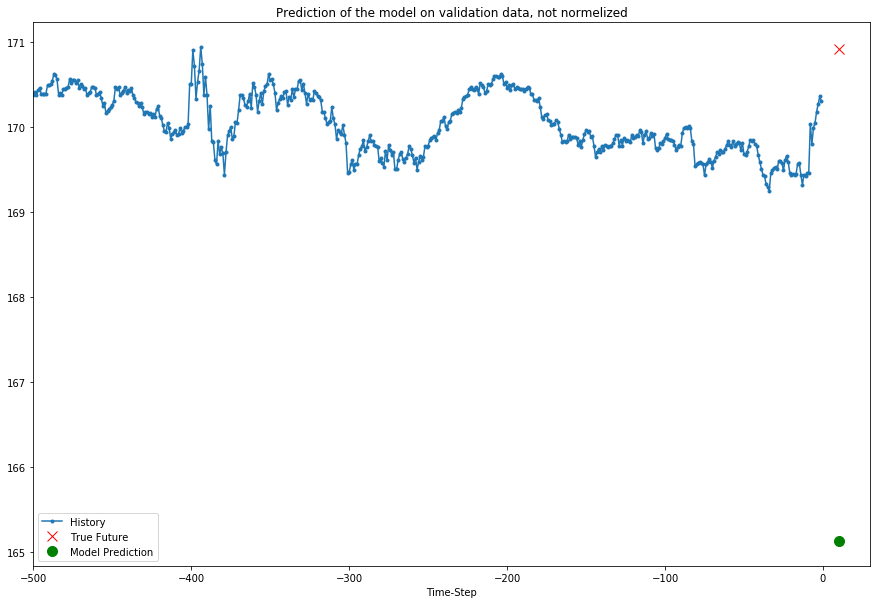

In [233]:
plot_one_prediction_from_generator(model, normelize_dataset.validation.generator(shuffle=True))

In [222]:
print(f"CNN model PnL: {calculate_model_pnl(model , normelize_dataset, 'validation')}")

CNN model PnL: -5.865853651361612e-05
